In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from diffusers import AutoencoderKL
import wandb
import os
from PIL import Image


In [2]:
# Custom Dataset
class MRIDataset3ch(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("L")  # Load as greyscale
        image = image.convert("RGB")  # Convert to 3-channel RGB
        if self.transform:
            image = self.transform(image)
        return image

# Configuration
image_size = 64
batch_size = 32
epochs = 20
lr = 1e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
data_path = "/home/benet/data/VH2D/images/flair"
save_path = "vae_checkpoints_CompVis"
os.makedirs(save_path, exist_ok=True)

# Transformations
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

# Load dataset
image_paths = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith(".png")]
dataset = MRIDataset3ch(image_paths, transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [4]:


# Load pretrained VAE
# vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse").to(device)
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)

vae.train()

# Optimizer
optimizer = optim.AdamW(vae.parameters(), lr=lr)
criterion = nn.MSELoss()

# Initialize Weights & Biases
wandb.init(project="vae-fine-tuning", config={"epochs": epochs, "batch_size": batch_size, "lr": lr})

# Training Loop
for epoch in range(epochs):
    total_loss = 0
    for batch in dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        latents = vae.encode(batch).latent_dist.sample()
        reconstructions = vae.decode(latents).sample
        loss = criterion(reconstructions, batch)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    wandb.log({"epoch": epoch+1, "loss": avg_loss})
    
    # Save checkpoint
    torch.save(vae.state_dict(), os.path.join(save_path, f"vae_epoch_{epoch+1}.pth"))

vae.save_pretrained(save_path)  # This ensures a proper config.json is created
wandb.finish()
print("Training completed!")


Epoch 1/20, Loss: 0.0057
Epoch 2/20, Loss: 0.0020
Epoch 3/20, Loss: 0.0015
Epoch 4/20, Loss: 0.0013
Epoch 5/20, Loss: 0.0012
Epoch 6/20, Loss: 0.0011
Epoch 7/20, Loss: 0.0010
Epoch 8/20, Loss: 0.0010
Epoch 9/20, Loss: 0.0009
Epoch 10/20, Loss: 0.0009
Epoch 11/20, Loss: 0.0009
Epoch 12/20, Loss: 0.0008
Epoch 13/20, Loss: 0.0008
Epoch 14/20, Loss: 0.0008
Epoch 15/20, Loss: 0.0007
Epoch 16/20, Loss: 0.0007
Epoch 17/20, Loss: 0.0007
Epoch 18/20, Loss: 0.0007
Epoch 19/20, Loss: 0.0006
Epoch 20/20, Loss: 0.0006


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
loss,0.00061


Training completed!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.012204232..0.76904505].


Latents Shape: torch.Size([1, 4, 8, 8])


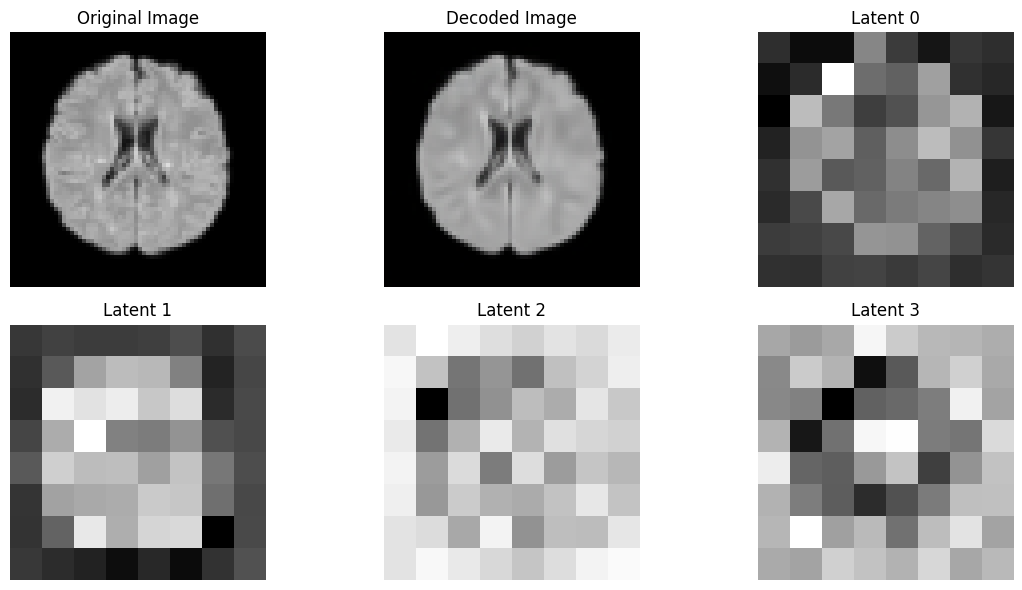

In [5]:
from diffusers import AutoencoderKL
import torch
import matplotlib.pyplot as plt
import numpy as np

# Load your fine-tuned VAE
vae = AutoencoderKL.from_pretrained("vae_checkpoints")  # Replace with actual path
vae.to("cuda").eval()

# Get Image from Dataset
image = dataset[0]  # (3, 64, 64)
image = image.unsqueeze(0).to("cuda")  # Add batch dimension -> (1, 3, 64, 64)

# Encode into latents
with torch.no_grad():
    latents = vae.encode(image).latent_dist.sample()  # Shape: (1, latent_channels, latent_height, latent_width)

print("Latents Shape:", latents.shape)  # Expected: (1, 4, 32, 32) if VAE compresses by factor 2

# Decode latents
with torch.no_grad():
    decoded = vae.decode(latents).sample  # Shape: (1, 3, 64, 64)

# Convert tensors to NumPy
image_np = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # (64, 64, 3)
decoded_np = decoded.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # (64, 64, 3)
latents_np = latents.squeeze(0).cpu().numpy()  # (4, 32, 32)

# Plot results
plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
plt.imshow(image_np, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 3, 2)
plt.imshow(decoded_np, cmap="gray")
plt.title("Decoded Image")
plt.axis("off")

for i in range(min(4, latents_np.shape[0])):  # Only plot first 4 latents
    plt.subplot(2, 3, i + 3)
    plt.imshow(latents_np[i], cmap="gray")
    plt.title(f"Latent {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.019773344..0.75065035].


Latents Shape: torch.Size([1, 4, 8, 8])


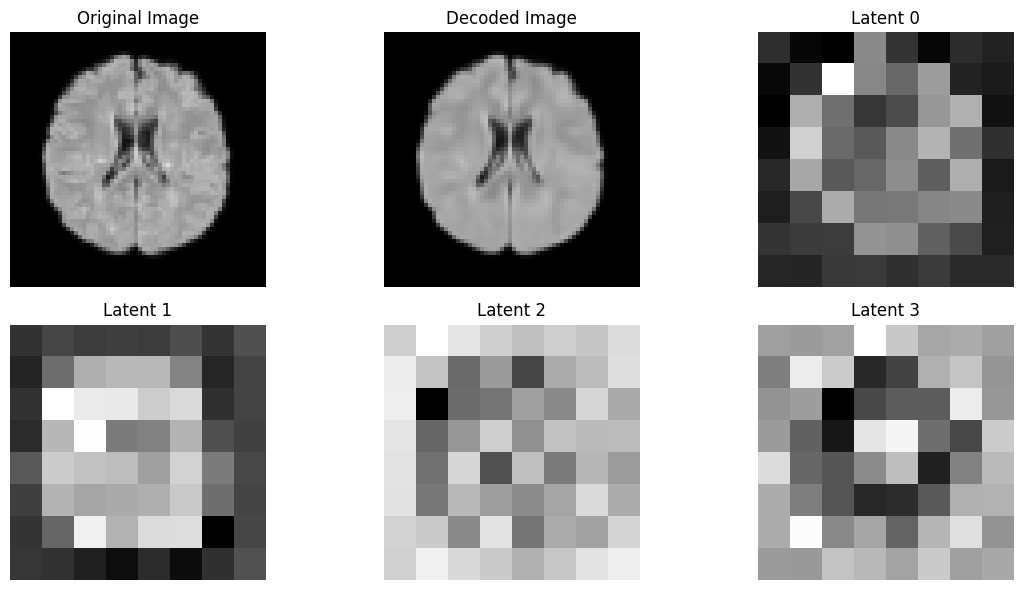

In [8]:
# Load your fine-tuned VAE
vae = AutoencoderKL.from_pretrained("vae_checkpoints_CompVis")  # Replace with actual path
vae.to("cuda").eval()

# Get Image from Dataset
image = dataset[0]  # (3, 64, 64)
image = image.unsqueeze(0).to("cuda")  # Add batch dimension -> (1, 3, 64, 64)

# Encode into latents
with torch.no_grad():
    latents = vae.encode(image).latent_dist.sample()  # Shape: (1, latent_channels, latent_height, latent_width)

print("Latents Shape:", latents.shape)  # Expected: (1, 4, 32, 32) if VAE compresses by factor 2

# Decode latents
with torch.no_grad():
    decoded = vae.decode(latents).sample  # Shape: (1, 3, 64, 64)

# Convert tensors to NumPy
image_np = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # (64, 64, 3)
decoded_np = decoded.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # (64, 64, 3)
latents_np = latents.squeeze(0).cpu().numpy()  # (4, 32, 32)

# Plot results
plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
plt.imshow(image_np, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 3, 2)
plt.imshow(decoded_np, cmap="gray")
plt.title("Decoded Image")
plt.axis("off")

for i in range(min(4, latents_np.shape[0])):  # Only plot first 4 latents
    plt.subplot(2, 3, i + 3)
    plt.imshow(latents_np[i], cmap="gray")
    plt.title(f"Latent {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()
